In [1]:
# Core libraries
import os, sys, random
from pathlib import Path
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader

# HF tokenizer only (no Trainer here)
from transformers import AutoTokenizer

# Sk-learn metrics for confusion matrix later
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import wandb

In [2]:
# --------------------------------------------------
#  Project-specific paths and helper modules
# --------------------------------------------------
project_dir = Path().resolve().parent          # <repo_root>/
src_dir     = project_dir / "src"
sys.path.append(str(src_dir))

try:
    from paths import DATA_CLEANED, DATA_PROCESSED
except ModuleNotFoundError:
    DATA_CLEANED   = project_dir / "data" / "cleaned"
    DATA_PROCESSED = project_dir / "data" / "processed"

# helper_functions & models from your repo
from helper_functions import (
    HateSpeechDataset,
    train_model,
    test_model,
    get_class_distribution,
    oversample_dataset,
    undersample_dataset
)
from models import BaseCNNClassifier

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [3]:
model_name = "xlnet-base-cased"
tokenizer   = AutoTokenizer.from_pretrained(model_name)

label_col = "task_1"

# cleaned TSV files
train_path = DATA_CLEANED / "hasoc_2019_en_train_cleaned.tsv"
test_path  = DATA_CLEANED / "hasoc_2019_en_test_cleaned.tsv"

df_train_full = pd.read_csv(train_path, sep="\t")
df_test       = pd.read_csv(test_path,  sep="\t")

# stratified split 70 / 30
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(
    df_train_full,
    test_size=0.30,
    random_state=42,
    stratify=df_train_full[label_col]
)

# map HOF / NOT → 1 / 0
label_list = sorted(train_df[label_col].unique())
label_map  = {lab: idx for idx, lab in enumerate(label_list)}
for split in (train_df, val_df, df_test):
    split[label_col] = split[label_col].map(label_map)

print("Class distribution:", get_class_distribution(train_df, label_col))


Class distribution: {1: 2513, 0: 1583}


In [4]:
imbalance_mode = "class_weighting"   # options: 'class_weighting', 'oversampling', 'undersampling'

if imbalance_mode == "oversampling":
    train_df = oversample_dataset(train_df, label_col)
elif imbalance_mode == "undersampling":
    train_df = undersample_dataset(train_df, label_col)


In [5]:
# Build datasets with a longer maximum length
train_ds = HateSpeechDataset(train_df, tokenizer, label=label_col, max_len=256)
val_ds   = HateSpeechDataset(val_df,   tokenizer, label=label_col, max_len=256)
test_ds  = HateSpeechDataset(df_test,  tokenizer, label=label_col, max_len=256)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=16)
test_loader  = DataLoader(test_ds,  batch_size=32)


In [6]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_df[label_col]),
    y=train_df[label_col]
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)


In [7]:
# Unfreeze ALL 12 transformer layers
unfreeze_last_layers = 12         

model = BaseCNNClassifier(
    model_name,
    class_weights_tensor,
    device,
    unfreeze_last_layers      # positional arg
).to(device)


2025-05-21 08:22:47.211494: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-21 08:22:47.228060: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747808567.248338  127212 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747808567.254672  127212 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747808567.269348  127212 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 


Epoch 1
Training Loss: 0.6361
Train Accuracy: 0.6482
Train F1 (macro): 0.6281

Val Loss: 0.7035
Val Accuracy: 0.5393
Val F1 (macro): 0.5352

New best model saved (F1: 0.5352, Acc: 0.5393)

Epoch 2
Training Loss: 0.6344
Train Accuracy: 0.6438
Train F1 (macro): 0.6335

Val Loss: 0.7127
Val Accuracy: 0.5308
Val F1 (macro): 0.5235


Epoch 3
Training Loss: 0.6347
Train Accuracy: 0.6484
Train F1 (macro): 0.6380

Val Loss: 0.7230
Val Accuracy: 0.5245
Val F1 (macro): 0.5144


Epoch 4
Training Loss: 0.6351
Train Accuracy: 0.6360
Train F1 (macro): 0.6263

Val Loss: 0.7071
Val Accuracy: 0.5342
Val F1 (macro): 0.5288


Epoch 5
Training Loss: 0.6356
Train Accuracy: 0.6428
Train F1 (macro): 0.6330

Val Loss: 0.7037
Val Accuracy: 0.5342
Val F1 (macro): 0.5292


Epoch 6
Training Loss: 0.6271
Train Accuracy: 0.6489
Train F1 (macro): 0.6385

Val Loss: 0.7157
Val Accuracy: 0.5233
Val F1 (macro): 0.5147


Epoch 7
Training Loss: 0.6249
Train Accuracy: 0.6606
Train F1 (macro): 0.6506

Val Loss: 0.7137
Val 

current_lr,▅██▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁
test_f1_macro,▁
test_f1_weighted,▁
test_loss,▁
test_precision_macro,▁
test_recall_macro,▁
train_accuracy,▅▄▅▂▄▅█▁▅▃▄▅▅▅▄▂▄▅▄▃
train_f1_macro,▂▄▅▂▄▅█▁▅▃▄▄▅▅▅▂▄▅▅▃
train_f1_weighted,▄▄▅▂▄▅█▁▅▃▄▅▅▅▄▂▄▅▄▃


Final test metrics: {'f1': 0.5277400211167611, 'accuracy': 0.5316565481352992}


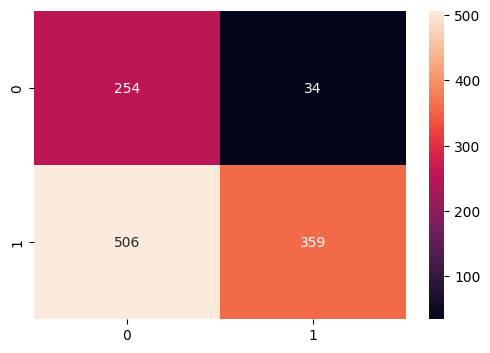

In [11]:
import wandb
from transformers import get_linear_schedule_with_warmup

lr      = 2e-6         # smaller LR for full fine-tune
epochs  = 20           # XLNet usually converges in <10 epochs

# Optimise ALL parameters now
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)

total_steps  = len(train_loader) * epochs
warmup_steps = int(0.1 * total_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = warmup_steps,
    num_training_steps = total_steps
)

wandb.init(
    project = "xlnet-hate-speech",
    config  = dict(
        model_name      = model_name,
        unfrozen_layers = unfreeze_last_layers,
        epochs          = epochs,
        lr              = lr,
        max_len         = 256,
        imbalance_mode  = imbalance_mode
    )
)


# train_model signature:
train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    epochs,
    "best_xlnet.pt",
    scheduler = scheduler                 # ← pass the scheduler
)


# Load the best checkpoint
model.load_state_dict(torch.load("best_xlnet.pt", weights_only=True))

# Final evaluation on the held-out test set
test_metrics = test_model(model, test_loader, device, phase="test")
print("Final test metrics:", test_metrics)

# ── CLOSE the W&B run ────────────────────────────────────────────────
import wandb
wandb.finish()          # <— this line explicitly ends the run